In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib
import math

# Data Collection and Dataframe Creation

In [2]:
pd.options.display.max_columns = None

In [4]:
# Get the league ID from the user
league_id = input("Enter the league ID: ")

# Create the URL using an f-string
url = f'https://fantasy.premierleague.com/api/leagues-classic/{league_id}/standings/'

try:
    # Make the request and parse the response as JSON
    response = requests.get(url)
    response.raise_for_status()  # Check for HTTP request errors
    data = response.json()
except requests.exceptions.RequestException as e:
    print(f"Request error: {e}")
except requests.exceptions.JSONDecodeError:
    print("The response is not a valid JSON document.")

Enter the league ID:  414849


In [5]:
#Extract data for the DataFrame
new_entries = data.get('new_entries', {})
last_updated_data = data.get('last_updated_data', None)
league = data.get('league', {})
standings = data.get('standings', {}).get('results', [])

# Create DataFrames for each key if they are not empty
if new_entries:
    df_new_entries = pd.DataFrame(new_entries.get('results', []))
else:
    df_new_entries = pd.DataFrame()

if league:
    df_league = pd.DataFrame([league])  # Convert dictionary to a DataFrame with one row
else:
    df_league = pd.DataFrame()

if standings:
    df_standings = pd.DataFrame(standings)
else:
    df_standings = pd.DataFrame()

# Extract the columns of interest
columns_of_interest = ['entry', 'entry_name', 'rank', 'player_name', 'total']
df_filtered_standings = df_standings[columns_of_interest]


In [6]:
def fetch_team_history(team_id):
    url = f'https://fantasy.premierleague.com/api/entry/{team_id}/history/'
    response = requests.get(url)
    response.raise_for_status()  # Check for HTTP request errors
    return response.json()

# Initialize a list to store the results
all_histories = []

# Loop through each entry in the filtered standings DataFrame
for team_id in df_filtered_standings['entry']:
    try:
        history_data = fetch_team_history(team_id)
        # Flatten the JSON and add the team id for reference
        for history in history_data.get('current', []):
            history['entry_id'] = team_id  # Use a different key name to avoid confusion with DataFrame columns
            all_histories.append(history)
    except requests.exceptions.RequestException as e:
        print(f"Request error for team id {team_id}: {e}")

# Create a new DataFrame from the collected history data
df_team_histories = pd.DataFrame(all_histories)

# Extract only the columns of interest
columns_of_interest = ['entry_id', 'event', 'points', 'total_points', 'value', 'points_on_bench']
df_team_histories_filtered = df_team_histories[columns_of_interest]


In [20]:
# Extracting league name from df_league DataFrame
league_name = df_league.loc[0, 'name']

# Assign league name to variable 'League Name'
League_Name = league_name

# Displaying league name
print("League Name:", League_Name)

League Name: EUSRC 2023/2024


In [7]:
import re

def sanitize_filename(filename):
    # Replace any characters that are not alphanumeric, spaces, or underscores with an underscore
    return re.sub(r'[^\w\s-]', '_', filename).strip().replace(' ', '_')

# Extracting league name from df_league DataFrame
league_name = df_league.loc[0, 'name']

# Assign original league name to variable 'League_Name'
League_Name = league_name

# Create a sanitized version of the league name
League_Name2 = sanitize_filename(league_name)


# League Page stats creation
### Not all outputs are optimal, use the variables though

In [7]:
# Winner

# Filter the DataFrame to find the player with rank 1
winner = df_filtered_standings[df_filtered_standings['rank'] == 1]

# Extract player details if needed
if not winner.empty:
    winner_player_name = winner.iloc[0]['player_name']
    winner_entry_name = winner.iloc[0]['entry_name']
    winner_details = f"{winner_player_name} - {winner_entry_name}"
    print(f"The winner is: {winner_details}")
else:
    print("No winner found with rank 1.")

The winner is: Theo Murray - The Special One


In [8]:
# Best Week
# Find the entry with the highest points
max_points_entry_idx = df_team_histories_filtered['points'].idxmax()
max_points_entry = df_team_histories_filtered.loc[max_points_entry_idx, 'entry_id']
max_points_week_points = df_team_histories_filtered.loc[max_points_entry_idx, 'points']

# Find the corresponding player details in df_filtered_standings
player_details = df_filtered_standings[df_filtered_standings['entry'] == max_points_entry]

if not player_details.empty:
    player_name = player_details.iloc[0]['player_name']
    entry_name = player_details.iloc[0]['entry_name']
    highest_points_player = f"{player_name} - {entry_name}"
    print(f"The player with the highest points is: {highest_points_player}")
    print(f"Points attained in that week: {max_points_week_points}")
else:
    print("No player found with the highest points.")

The player with the highest points is: Theo Murray - The Special One
Points attained in that week: 134


In [9]:
#Worst Week
# Find the entry with the absolute lowest points
min_points_entry_idx = df_team_histories_filtered['points'].idxmin()
min_points_entry = df_team_histories_filtered.loc[min_points_entry_idx, 'entry_id']
min_points_week = df_team_histories_filtered.loc[min_points_entry_idx, 'event']
min_points_week_points = df_team_histories_filtered.loc[min_points_entry_idx, 'points']

# Find the corresponding player details in df_filtered_standings
player_details = df_filtered_standings[df_filtered_standings['entry'] == min_points_entry]

if not player_details.empty:
    player_name = player_details.iloc[0]['player_name']
    entry_name = player_details.iloc[0]['entry_name']
    worst_points_player = f"{player_name} - {entry_name}"
    print(f"The player with the lowest points in any week is: {worst_points_player} in Week {min_points_week} with {min_points_week_points} points.")
else:
    print("No player found with the lowest points.")

The player with the lowest points in any week is: Stephen Macleod - Super John McGinn in Week 29 with 2 points.


In [17]:
# Highest total points on the bench
# Calculate total points on the bench for each entry
total_points_on_bench = df_team_histories_filtered.groupby('entry_id')['points_on_bench'].sum()

# Find the entry with the highest total points on the bench
max_points_on_bench_entry = total_points_on_bench.idxmax()
max_points_on_bench = total_points_on_bench[max_points_on_bench_entry]

# Find the corresponding player details in df_filtered_standings
player_details = df_filtered_standings[df_filtered_standings['entry'] == max_points_on_bench_entry]

if not player_details.empty:
    player_name = player_details.iloc[0]['player_name']
    entry_name = player_details.iloc[0]['entry_name']
    highest_points_on_bench_player = f"{player_name} - {entry_name}"
    print(f"The player with the highest total points on the bench is: {highest_points_on_bench_player} with {max_points_on_bench} points on the bench.")
else:
    print("No player found with the highest total points on the bench.")

The player with the highest total points on the bench is: Ken Murray - MK Munchengladbach with 277 points on the bench.


In [10]:
# Highest points on the bench in a week

# Find the entry with the highest points on the bench
max_points_on_bench_entry_id = df_team_histories_filtered.loc[df_team_histories_filtered['points_on_bench'].idxmax(), 'entry_id']

# Find the corresponding player details in df_filtered_standings
player_details = df_filtered_standings[df_filtered_standings['entry'] == max_points_on_bench_entry_id]

if not player_details.empty:
    player_name = player_details.iloc[0]['player_name']
    entry_name = player_details.iloc[0]['entry_name']
    points_on_bench = df_team_histories_filtered.loc[df_team_histories_filtered['entry_id'] == max_points_on_bench_entry_id, 'points_on_bench'].max()
    highest_points_on_bench_player = f"{player_name} - {entry_name} ({points_on_bench} points on bench)"
    print(f"The player with the highest points on the bench is: {highest_points_on_bench_player}")
else:
    print("No player found with the highest points on the bench.")

The player with the highest points on the bench is: Andy Macleod - Macleod (27 points on bench)


In [23]:
# Sum the total points on the bench for each entry
total_bench_points = df_team_histories_filtered.groupby('entry_id')['points_on_bench'].sum()

# Find the entry with the lowest total points on the bench
min_bench_points_entry = total_bench_points.idxmin()
min_bench_points_value = total_bench_points.min()

# Find the corresponding player details in df_filtered_standings
player_details = df_filtered_standings[df_filtered_standings['entry'] == min_bench_points_entry]

if not player_details.empty:
    player_name = player_details.iloc[0]['player_name']
    entry_name = player_details.iloc[0]['entry_name']
    lowest_bench_points_player = f"{player_name} - {entry_name}"
    print(f"The player with the lowest total points on the bench is: {lowest_bench_points_player} with {min_bench_points_value} points.")
else:
    print("No player found with the lowest total points on the bench.")

The player with the lowest total points on the bench is: Stephen Macleod - Super John McGinn with 88 points.


In [11]:
#Highest team value at any moment

# Find the entry with the highest team value
max_value_entry_id = df_team_histories_filtered.loc[df_team_histories_filtered['value'].idxmax(), 'entry_id']

# Find the corresponding player details in df_filtered_standings
player_details = df_filtered_standings[df_filtered_standings['entry'] == max_value_entry_id]

if not player_details.empty:
    player_name = player_details.iloc[0]['player_name']
    entry_name = player_details.iloc[0]['entry_name']
    max_value = df_team_histories_filtered.loc[df_team_histories_filtered['entry_id'] == max_value_entry_id, 'value'].max()
    highest_value_player = f"{player_name} - {entry_name} (Team value: {max_value})"
    print(f"The player with the highest team value is: {highest_value_player}")
else:
    print("No player found with the highest team value.")

The player with the highest team value is: Theo Murray - The Special One (Team value: 1056)


In [12]:
#Lowest team value at any moment 

# Find the entry with the lowest team value
min_value_entry_id = df_team_histories_filtered.loc[df_team_histories_filtered['value'].idxmin(), 'entry_id']

# Find the corresponding player details in df_filtered_standings
player_details = df_filtered_standings[df_filtered_standings['entry'] == min_value_entry_id]

if not player_details.empty:
    player_name = player_details.iloc[0]['player_name']
    entry_name = player_details.iloc[0]['entry_name']
    min_value = df_team_histories_filtered.loc[df_team_histories_filtered['entry_id'] == min_value_entry_id, 'value'].min()
    lowest_value_player = f"{player_name} - {entry_name} (Team value: {min_value})"
    print(f"The player with the lowest team value is: {lowest_value_player}")
else:
    print("No player found with the lowest team value.")

The player with the lowest team value is: John Macleod - Harris St germain (Team value: 986)


In [24]:
# Highest finishing team value

# Filter data for week 38 only
df_week_38 = df_team_histories_filtered[df_team_histories_filtered['event'] == 38]

# Find the entry with the highest value in week 38
max_value_entry_id = df_week_38.loc[df_week_38['value'].idxmax(), 'entry_id']

# Find the corresponding player details in df_filtered_standings
player_details = df_filtered_standings[df_filtered_standings['entry'] == max_value_entry_id]

if not player_details.empty:
    player_name = player_details.iloc[0]['player_name']
    entry_name = player_details.iloc[0]['entry_name']
    max_value_player = f"{player_name} - {entry_name} (Value: {df_week_38.loc[df_week_38['entry_id'] == max_value_entry_id, 'value'].values[0]})"
    print(f"The player with the highest team value in week 38 is: {max_value_player}")
else:
    print("No player found with the highest team value in week 38.")

The player with the highest team value in week 38 is: Theo Murray - The Special One (Value: 1055)


In [13]:
#Most weeks won & Lost

# Initialize dictionaries to store winners and losers
winners = {}
losers = {}

# Iterate through each unique week (event)
for week in df_team_histories_filtered['event'].unique():
    # Filter data for the current week
    df_week = df_team_histories_filtered[df_team_histories_filtered['event'] == week]
    
    # Find the entry with the highest points in the current week
    max_points_entry_id = df_week.loc[df_week['points'].idxmax(), 'entry_id']
    max_points_player_details = df_filtered_standings[df_filtered_standings['entry'] == max_points_entry_id]
    
    if not max_points_player_details.empty:
        max_points_player_name = max_points_player_details.iloc[0]['player_name']
        max_points_entry_name = max_points_player_details.iloc[0]['entry_name']
        winner_key = (max_points_player_name, max_points_entry_name)
        
        if winner_key in winners:
            winners[winner_key] += 1
        else:
            winners[winner_key] = 1

    # Find the entry with the lowest points in the current week
    min_points_entry_id = df_week.loc[df_week['points'].idxmin(), 'entry_id']
    min_points_player_details = df_filtered_standings[df_filtered_standings['entry'] == min_points_entry_id]
    
    if not min_points_player_details.empty:
        min_points_player_name = min_points_player_details.iloc[0]['player_name']
        min_points_entry_name = min_points_player_details.iloc[0]['entry_name']
        loser_key = (min_points_player_name, min_points_entry_name)
        
        if loser_key in losers:
            losers[loser_key] += 1
        else:
            losers[loser_key] = 1

# Find the player and team who have won the most number of weeks
most_wins = max(winners, key=winners.get)
most_wins_count = winners[most_wins]

# Find the player and team who have lost the most number of weeks
most_losses = max(losers, key=losers.get)
most_losses_count = losers[most_losses]

# Print the results
print(f"Player and team with the most wins: {most_wins} (Wins: {most_wins_count})")
print(f"Player and team with the most losses: {most_losses} (Losses: {most_losses_count})")


Player and team with the most wins: ('Theo Murray', 'The Special One') (Wins: 9)
Player and team with the most losses: ('John Macleod', 'Harris St germain') (Losses: 11)


# League Graph Creation

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_filtered_standings is already defined and populated

# Create a unique list of player-team combinations
unique_combinations = df_filtered_standings.apply(lambda x: f"{x['player_name']} - {x['entry_name']}", axis=1).unique()

# Create a color map for these combinations
color_map = {}
colors = plt.cm.tab20.colors if len(unique_combinations) <= 20 else plt.cm.get_cmap('tab20b', len(unique_combinations)).colors

for i, combination in enumerate(unique_combinations):
    color_map[combination] = colors[i % len(colors)]

/private/var/mobile/Containers/Data/Application/96EBA80A-BB93-4D79-A195-4C8A99C2EB54/tmp/ipykernel_3455/1509734915.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.tab20.colors if len(unique_combinations) <= 20 else plt.cm.get_cmap('tab20b', len(unique_combinations)).colors


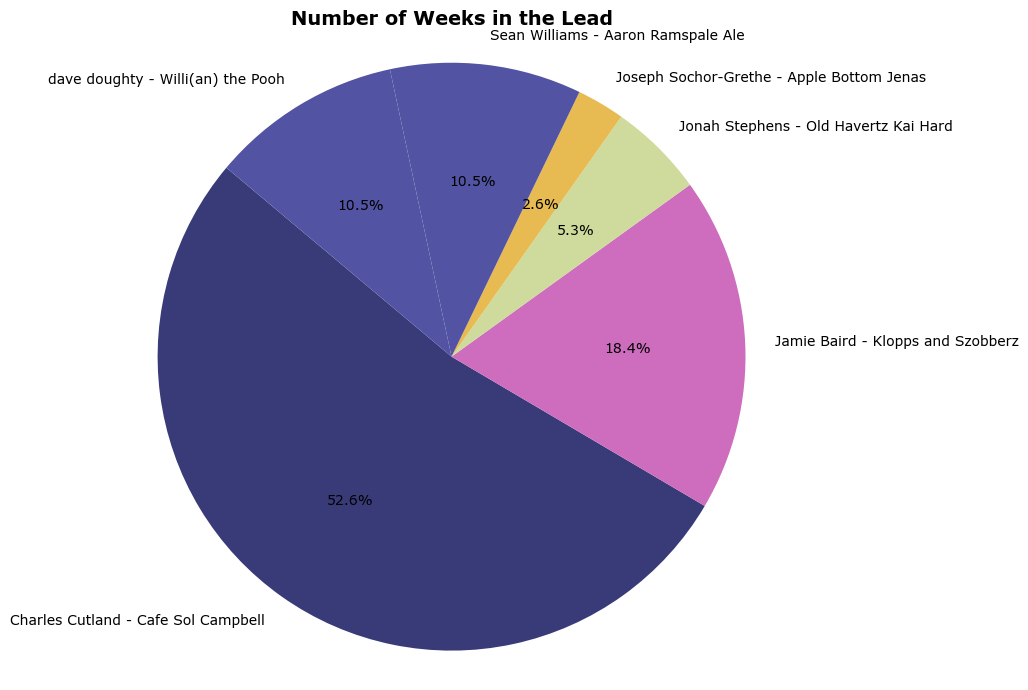

In [36]:
# Step 1: Identify the highest total_points for every event (week)
leading_entries = df_team_histories_filtered.loc[df_team_histories_filtered.groupby('event')['total_points'].idxmax()]

# Step 2: Link entry IDs to player names and team names
leading_entries = leading_entries.reset_index()  # Reset index to work with .merge()
leading_entries = leading_entries.merge(df_filtered_standings, left_on='entry_id', right_on='entry')

# Step 3: Count the number of weeks each player was in the lead
leading_counts = leading_entries.groupby(['player_name', 'entry_name']).size().reset_index(name='weeks_in_lead')

# Prepare data for the pie chart
labels = [f"{row['player_name']} - {row['entry_name']}" for _, row in leading_counts.iterrows()]
sizes = leading_counts['weeks_in_lead']
chart_colors = [color_map[label] for label in labels]

# Step 4: Create a pie chart using Matplotlib with the specified theme
plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=chart_colors)
plt.title('Number of Weeks in the Lead', fontsize=14, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.savefig('graph1.png', bbox_inches = 'tight')

In [37]:
# Step 1: Identify the highest points for every event (week)
weekly_winners = df_team_histories_filtered.loc[df_team_histories_filtered.groupby('event')['points'].idxmax()]

# Step 2: Link these points to the corresponding player name and team name
weekly_winners = weekly_winners.merge(df_filtered_standings, left_on='entry_id', right_on='entry')

# Step 3: Count the number of weeks won by each player
weekly_winners_count = weekly_winners.groupby(['player_name', 'entry_name']).size().reset_index(name='weeks_won')

# Prepare data for the pie chart
labels = [f"{row['player_name']} - {row['entry_name']}" for _, row in weekly_winners_count.iterrows()]
sizes = weekly_winners_count['weeks_won']
chart_colors = [color_map[label] for label in labels]

# Step 4: Create a pie chart using Matplotlib with the specified theme
plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=chart_colors)
plt.title('Proportion of Weeks Won by Individuals', fontsize=14, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.savefig('graph 2.png',bbox_inches = 'tight')
plt.close()

In [38]:
# Calculate the cumulative points for each entry over the gameweeks
df_team_histories_filtered['cumulative_points'] = df_team_histories_filtered.groupby('entry_id')['points'].cumsum()

# Create a plot for cumulative points gained by individuals
plt.figure(figsize=(12, 8))

# Iterate through each entry and plot the cumulative points
for entry_id in df_filtered_standings['entry']:
    player_data = df_team_histories_filtered[df_team_histories_filtered['entry_id'] == entry_id]
    player_name = df_filtered_standings[df_filtered_standings['entry'] == entry_id]['player_name'].values[0]
    entry_name = df_filtered_standings[df_filtered_standings['entry'] == entry_id]['entry_name'].values[0]
    label = f"{player_name} - {entry_name}"
    plt.plot(player_data['event'], player_data['cumulative_points'], label=label, color=color_map[label])

# Add labels and title
plt.xlabel('Gameweeks', fontweight='bold')
plt.ylabel('Cumulative Points', fontweight='bold')
plt.title('Cumulative Points Gained by Individuals Over Gameweeks', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend to be outside the plot
plt.grid(True)
plt.tight_layout()
plt.savefig('graph 3.png')
plt.close()

/private/var/mobile/Containers/Data/Application/96EBA80A-BB93-4D79-A195-4C8A99C2EB54/tmp/ipykernel_3455/1403924542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team_histories_filtered['cumulative_points'] = df_team_histories_filtered.groupby('entry_id')['points'].cumsum()


In [39]:
# Calculate the average points per gameweek
average_points_per_week = df_team_histories_filtered.groupby('event')['points'].mean()

# Create a plot for points gained per gameweek by individuals
plt.figure(figsize=(12, 8))

# Iterate through each entry and plot the points per gameweek
for entry_id in df_filtered_standings['entry']:
    player_data = df_team_histories_filtered[df_team_histories_filtered['entry_id'] == entry_id]
    player_name = df_filtered_standings[df_filtered_standings['entry'] == entry_id]['player_name'].values[0]
    entry_name = df_filtered_standings[df_filtered_standings['entry'] == entry_id]['entry_name'].values[0]
    label = f"{player_name} - {entry_name}"
    plt.plot(player_data['event'], player_data['points'], label=label, color=color_map[label])

# Plot the average points per gameweek
plt.plot(average_points_per_week.index, average_points_per_week, 'k--', label='Average Points')

# Add labels and title
plt.xlabel('Gameweeks', fontweight='bold')
plt.ylabel('Points', fontweight='bold')
plt.title('Points Gained Per Gameweek by Individuals', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend to be outside the plot
plt.grid(True)
plt.tight_layout()
plt.savefig('graph 4.png')
plt.close()

In [40]:
# Initialize a dictionary to hold cumulative points for each player
cumulative_points = {entry_id: [] for entry_id in df_filtered_standings['entry']}

# Initialize a dictionary to hold points behind the leader for each player
points_behind_leader = {entry_id: [] for entry_id in df_filtered_standings['entry']}

# Loop through each gameweek
for gameweek in sorted(df_team_histories_filtered['event'].unique()):
    # Calculate cumulative points for each player up to the current gameweek
    for entry_id in cumulative_points.keys():
        cumulative_points[entry_id].append(df_team_histories_filtered[
            (df_team_histories_filtered['entry_id'] == entry_id) & 
            (df_team_histories_filtered['event'] <= gameweek)
        ]['points'].sum())

    # Find the leader's points for the current gameweek
    leader_points = max([cumulative_points[entry_id][-1] for entry_id in cumulative_points.keys()])
    
    # Calculate points behind the leader for each player
    for entry_id in points_behind_leader.keys():
        points_behind_leader[entry_id].append(leader_points - cumulative_points[entry_id][-1])

# Create a plot for points behind the leader per gameweek
plt.figure(figsize=(12, 8))

# Iterate through each entry and plot the points behind the leader per gameweek
for entry_id in points_behind_leader.keys():
    player_name = df_filtered_standings[df_filtered_standings['entry'] == entry_id]['player_name'].values[0]
    entry_name = df_filtered_standings[df_filtered_standings['entry'] == entry_id]['entry_name'].values[0]
    label = f"{player_name} - {entry_name}"
    plt.plot(sorted(df_team_histories_filtered['event'].unique()), points_behind_leader[entry_id], label=label, color=color_map[label])

# Add labels and title
plt.xlabel('Gameweeks', fontweight='bold')
plt.ylabel('Points Behind Leader', fontweight='bold')
plt.title('Points Behind Leader Per Gameweek by Individuals', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend to be outside the plot
plt.grid(True)
plt.tight_layout()
plt.savefig('graph 5.png')
plt.close()

In [41]:
# Create a DataFrame to store the ranks for each week
rank_history = pd.DataFrame()

# Calculate the ranks for each week based on total_points
for event in df_team_histories_filtered['event'].unique():
    weekly_data = df_team_histories_filtered[df_team_histories_filtered['event'] == event].copy()
    weekly_data.sort_values(by='total_points', ascending=False, inplace=True)
    weekly_data['rank'] = range(1, len(weekly_data) + 1)
    weekly_data['event'] = event
    rank_history = pd.concat([rank_history, weekly_data[['entry_id', 'rank', 'event']]])

# Pivot the table to get ranks in a suitable format for plotting
rank_history_pivot = rank_history.pivot(index='event', columns='entry_id', values='rank')

# Plot the rank changes
plt.figure(figsize=(14, 8))
for column in rank_history_pivot.columns:
    player_details = df_filtered_standings[df_filtered_standings['entry'] == column]
    if not player_details.empty:
        player_name = player_details.iloc[0]['player_name']
        entry_name = player_details.iloc[0]['entry_name']
        label = f"{player_name} - {entry_name}"
        plt.plot(rank_history_pivot.index, rank_history_pivot[column], marker='o', linestyle='-', label=label, color=color_map[label])

# Reverse the y-axis to show rank 1 at the top
plt.gca().invert_yaxis()

# Adding titles and labels
plt.title('Ranking Change Over Each Game Week', fontsize=14, fontweight='bold')
plt.xlabel('Game Week', fontweight='bold')
plt.ylabel('Rank', fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.savefig('graph 6.png')
plt.close()

# PDF Creation

In [27]:
pip install reportlab

Note: you may need to restart the kernel to use updated packages.


In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import A4
from reportlab.lib.styles import ParagraphStyle
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image

# Load the dataframes from the notebook environment (assuming the environment)
# df_filtered_standings and df_team_histories_filtered should be pre-loaded from the notebook

# Create a unique list of player-team combinations
unique_combinations = df_filtered_standings.apply(lambda x: f"{x['player_name']} - {x['entry_name']}", axis=1).unique()

# Create a color map for these combinations
color_map = {}
colors_list = plt.cm.tab20.colors if len(unique_combinations) <= 20 else plt.cm.get_cmap('tab20b', len(unique_combinations)).colors

for i, combination in enumerate(unique_combinations):
    color_map[combination] = colors_list[i % len(colors_list)]

# Function to extract and calculate the statistics

# Winner
winner = df_filtered_standings.loc[df_filtered_standings['rank'] == 1, ['player_name', 'entry_name']].iloc[0]
winner_str = f"{winner['player_name']} - {winner['entry_name']}"

# Best Week
best_week = df_team_histories_filtered.loc[df_team_histories_filtered['points'].idxmax()]
best_week_player = df_filtered_standings[df_filtered_standings['entry'] == best_week['entry_id']]
best_week_str = f"{best_week_player.iloc[0]['player_name']} - {best_week_player.iloc[0]['entry_name']} ({best_week['points']} points)"

# Worst Week
worst_week = df_team_histories_filtered.loc[df_team_histories_filtered['points'].idxmin()]
worst_week_player = df_filtered_standings[df_filtered_standings['entry'] == worst_week['entry_id']]
worst_week_str = f"{worst_week_player.iloc[0]['player_name']} - {worst_week_player.iloc[0]['entry_name']} ({worst_week['points']} points)"

# Most Weeks Won
weekly_winners = df_team_histories_filtered.loc[df_team_histories_filtered.groupby('event')['points'].idxmax()]
weekly_winners_count = weekly_winners['entry_id'].value_counts()
most_weeks_won_entry = weekly_winners_count.idxmax()
most_weeks_won_player = df_filtered_standings[df_filtered_standings['entry'] == most_weeks_won_entry]
most_weeks_won_str = f"{most_weeks_won_player.iloc[0]['player_name']} - {most_weeks_won_player.iloc[0]['entry_name']} ({weekly_winners_count.max()} weeks)"

# Most Weeks Lost
weekly_losers = df_team_histories_filtered.loc[df_team_histories_filtered.groupby('event')['points'].idxmin()]
weekly_losers_count = weekly_losers['entry_id'].value_counts()
most_weeks_lost_entry = weekly_losers_count.idxmax()
most_weeks_lost_player = df_filtered_standings[df_filtered_standings['entry'] == most_weeks_lost_entry]
most_weeks_lost_str = f"{most_weeks_lost_player.iloc[0]['player_name']} - {most_weeks_lost_player.iloc[0]['entry_name']} ({weekly_losers_count.max()} weeks)"

# Most Total Points on the Bench
total_points_bench = df_team_histories_filtered.groupby('entry_id')['points_on_bench'].sum()
most_points_bench_entry = total_points_bench.idxmax()
most_points_bench_player = df_filtered_standings[df_filtered_standings['entry'] == most_points_bench_entry]
most_points_bench_str = f"{most_points_bench_player.iloc[0]['player_name']} - {most_points_bench_player.iloc[0]['entry_name']} ({total_points_bench.max()} points)"

# Least Total Points on the Bench
least_points_bench_entry = total_points_bench.idxmin()
least_points_bench_player = df_filtered_standings[df_filtered_standings['entry'] == least_points_bench_entry]
least_points_bench_str = f"{least_points_bench_player.iloc[0]['player_name']} - {least_points_bench_player.iloc[0]['entry_name']} ({total_points_bench.min()} points)"

# Highest Points on Bench in One Week
highest_points_bench = df_team_histories_filtered['points_on_bench'].max()
highest_points_bench_week = df_team_histories_filtered.loc[df_team_histories_filtered['points_on_bench'].idxmax()]
highest_points_bench_player = df_filtered_standings[df_filtered_standings['entry'] == highest_points_bench_week['entry_id']]
highest_points_bench_str = f"{highest_points_bench_player.iloc[0]['player_name']} - {highest_points_bench_player.iloc[0]['entry_name']} ({highest_points_bench} points)"

# Highest Weekly Team Value
highest_weekly_value = df_team_histories_filtered['value'].max()
highest_weekly_value_week = df_team_histories_filtered.loc[df_team_histories_filtered['value'].idxmax()]
highest_weekly_value_player = df_filtered_standings[df_filtered_standings['entry'] == highest_weekly_value_week['entry_id']]
highest_weekly_value_str = f"{highest_weekly_value_player.iloc[0]['player_name']} - {highest_weekly_value_player.iloc[0]['entry_name']} (£{highest_weekly_value / 10:.1f}m)"

# Lowest Weekly Team Value
lowest_weekly_value = df_team_histories_filtered['value'].min()
lowest_weekly_value_week = df_team_histories_filtered.loc[df_team_histories_filtered['value'].idxmin()]
lowest_weekly_value_player = df_filtered_standings[df_filtered_standings['entry'] == lowest_weekly_value_week['entry_id']]
lowest_weekly_value_str = f"{lowest_weekly_value_player.iloc[0]['player_name']} - {lowest_weekly_value_player.iloc[0]['entry_name']} (£{lowest_weekly_value / 10:.1f}m)"

# Highest Finishing Team Value
final_week = df_team_histories_filtered['event'].max()
final_values = df_team_histories_filtered[df_team_histories_filtered['event'] == final_week]
highest_finishing_value = final_values['value'].max()
highest_finishing_value_week = final_values.loc[final_values['value'].idxmax()]
highest_finishing_value_player = df_filtered_standings[df_filtered_standings['entry'] == highest_finishing_value_week['entry_id']]
highest_finishing_value_str = f"{highest_finishing_value_player.iloc[0]['player_name']} - {highest_finishing_value_player.iloc[0]['entry_name']} (£{highest_finishing_value / 10:.1f}m)"

# Generate the graphs

# Pie Chart: Number of Weeks in the Lead
leading_entries = df_team_histories_filtered.loc[df_team_histories_filtered.groupby('event')['total_points'].idxmax()]
leading_entries = leading_entries.reset_index().merge(df_filtered_standings, left_on='entry_id', right_on='entry')
leading_counts = leading_entries.groupby(['player_name', 'entry_name']).size().reset_index(name='weeks_in_lead')
labels = [f"{row['player_name']} - {row['entry_name']}" for _, row in leading_counts.iterrows()]
sizes = leading_counts['weeks_in_lead']
chart_colors = [color_map[label] for label in labels]

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=chart_colors)
plt.title('Number of Weeks in the Lead', fontsize=14, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.subplots_adjust(left=0.3, right=0.7, top=0.9, bottom=0.1)
plt.savefig('number_of_weeks_in_the_lead.png')
plt.close()

# Line Plot: Ranking Change Over Each Game Week
rank_history = pd.DataFrame()
for event in df_team_histories_filtered['event'].unique():
    weekly_data = df_team_histories_filtered[df_team_histories_filtered['event'] == event].copy()
    weekly_data.sort_values(by='total_points', ascending=False, inplace=True)
    weekly_data['rank'] = range(1, len(weekly_data) + 1)
    weekly_data['event'] = event
    rank_history = pd.concat([rank_history, weekly_data[['entry_id', 'rank', 'event']]])

rank_history_pivot = rank_history.pivot(index='event', columns='entry_id', values='rank')
plt.figure(figsize=(14, 8))
for column in rank_history_pivot.columns:
    player_details = df_filtered_standings[df_filtered_standings['entry'] == column]
    if not player_details.empty:
        player_name = player_details.iloc[0]['player_name']
        entry_name = player_details.iloc[0]['entry_name']
        label = f"{player_name} - {entry_name}"
        plt.plot(rank_history_pivot.index, rank_history_pivot[column], marker='o', linestyle='-', label=label, color=color_map[label])
plt.gca().invert_yaxis()
plt.title('Ranking Change Over Each Game Week', fontsize=14, fontweight='bold')
plt.xlabel('Game Week', fontsize=12, fontweight='bold')
plt.ylabel('Rank', fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('ranking_change_over_each_game_week.png')
plt.close()

# Line Plot: Cumulative Points Gained by Individuals
df_team_histories_filtered['cumulative_points'] = df_team_histories_filtered.groupby('entry_id')['points'].cumsum()
plt.figure(figsize=(12, 8))
for entry_id in df_filtered_standings['entry']:
    player_data = df_team_histories_filtered[df_team_histories_filtered['entry_id'] == entry_id]
    player_name = df_filtered_standings[df_filtered_standings['entry'] == entry_id]['player_name'].values[0]
    entry_name = df_filtered_standings[df_filtered_standings['entry'] == entry_id]['entry_name'].values[0]
    label = f"{player_name} - {entry_name}"
    plt.plot(player_data['event'], player_data['cumulative_points'], label=label, color=color_map[label])
plt.xlabel('Gameweeks', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Points', fontsize=12, fontweight='bold')
plt.title('Cumulative Points Gained by Individuals Over Gameweeks', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('cumulative_points_gained_by_individuals.png')
plt.close()

# Line Plot: Points Gained Per Gameweek
average_points_per_week = df_team_histories_filtered.groupby('event')['points'].mean()
plt.figure(figsize=(12, 8))
for entry_id in df_filtered_standings['entry']:
    player_data = df_team_histories_filtered[df_team_histories_filtered['entry_id'] == entry_id]
    player_name = df_filtered_standings[df_filtered_standings['entry'] == entry_id]['player_name'].values[0]
    entry_name = df_filtered_standings[df_filtered_standings['entry'] == entry_id]['entry_name'].values[0]
    label = f"{player_name} - {entry_name}"
    plt.plot(player_data['event'], player_data['points'], label=label, color=color_map[label])
plt.plot(average_points_per_week.index, average_points_per_week, 'k--', label='Average Points')
plt.xlabel('Gameweeks', fontsize=12, fontweight='bold')
plt.ylabel('Points', fontsize=12, fontweight='bold')
plt.title('Points Gained Per Gameweek by Individuals', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('points_gained_per_gameweek.png')
plt.close()

# Line Plot: Points Behind Leader Per Gameweek
cumulative_points = {entry_id: [] for entry_id in df_filtered_standings['entry']}
points_behind_leader = {entry_id: [] for entry_id in df_filtered_standings['entry']}
for gameweek in sorted(df_team_histories_filtered['event'].unique()):
    for entry_id in cumulative_points.keys():
        cumulative_points[entry_id].append(df_team_histories_filtered[
            (df_team_histories_filtered['entry_id'] == entry_id) & 
            (df_team_histories_filtered['event'] <= gameweek)
        ]['points'].sum())
    leader_points = max([cumulative_points[entry_id][-1] for entry_id in cumulative_points.keys()])
    for entry_id in points_behind_leader.keys():
        points_behind_leader[entry_id].append(leader_points - cumulative_points[entry_id][-1])
plt.figure(figsize=(12, 8))
for entry_id in points_behind_leader.keys():
    player_name = df_filtered_standings[df_filtered_standings['entry'] == entry_id]['player_name'].values[0]
    entry_name = df_filtered_standings[df_filtered_standings['entry'] == entry_id]['entry_name'].values[0]
    label = f"{player_name} - {entry_name}"
    plt.plot(sorted(df_team_histories_filtered['event'].unique()), points_behind_leader[entry_id], label=label, color=color_map[label])
plt.xlabel('Gameweeks', fontsize=12, fontweight='bold')
plt.ylabel('Points Behind Leader', fontsize=12, fontweight='bold')
plt.title('Points Behind Leader Per Gameweek by Individuals', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('points_behind_leader_per_gameweek.png')
plt.close()

# Pie Chart: Number of Weeks Won by Individuals
weekly_winners = df_team_histories_filtered.loc[df_team_histories_filtered.groupby('event')['points'].idxmax()]
weekly_winners = weekly_winners.reset_index().merge(df_filtered_standings, left_on='entry_id', right_on='entry')
weekly_winners_count = weekly_winners.groupby(['player_name', 'entry_name']).size().reset_index(name='weeks_won')
labels = [f"{row['player_name']} - {row['entry_name']}" for _, row in weekly_winners_count.iterrows()]
sizes = weekly_winners_count['weeks_won']
chart_colors = [color_map[label] for label in labels]

plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=chart_colors)
plt.title('Proportion of Weeks Won by Individuals', fontsize=14, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.savefig('proportion_of_weeks_won.png')
plt.close()

/private/var/mobile/Containers/Data/Application/96EBA80A-BB93-4D79-A195-4C8A99C2EB54/tmp/ipykernel_3455/3211841306.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors_list = plt.cm.tab20.colors if len(unique_combinations) <= 20 else plt.cm.get_cmap('tab20b', len(unique_combinations)).colors
/private/var/mobile/Containers/Data/Application/96EBA80A-BB93-4D79-A195-4C8A99C2EB54/tmp/ipykernel_3455/3211841306.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team_histories_filtered['cumulative_points'] = df_team_histories_filtered.groupby('entry_id')['points'].cumsum(

In [43]:
def calculate_ranks(df_team_histories):
    df_team_histories['rank'] = df_team_histories.groupby('event')['total_points'].rank(method='min', ascending=False).astype(int)
    return df_team_histories

# Apply the ranking calculation
df_team_histories_filtered = calculate_ranks(df_team_histories_filtered)
def collect_player_statistics(df_team_histories, df_standings):
    player_stats = {}

    for entry_id in df_team_histories['entry_id'].unique():
        player_data = df_team_histories[df_team_histories['entry_id'] == entry_id]
        standings_data = df_standings[df_standings['entry'] == entry_id]

        player_name = standings_data.iloc[0]['player_name']
        entry_name = standings_data.iloc[0]['entry_name']
        final_rank = standings_data.iloc[0]['rank']
        total_points = standings_data.iloc[0]['total']

        top_position = player_data['rank'].min()
        bottom_position = player_data['rank'].max()
        best_week_points = player_data['points'].max()
        worst_week_points = player_data['points'].min()
        total_points_on_bench = player_data['points_on_bench'].sum()
        most_points_on_bench = player_data['points_on_bench'].max()
        final_team_value = player_data[player_data['event'] == player_data['event'].max()]['value'].iloc[0]
        average_team_value = player_data['value'].mean()

        player_stats[entry_id] = {
            'player_name': player_name,
            'entry_name': entry_name,
            'final_rank': final_rank,
            'total_points': total_points,
            'top_position': top_position,
            'bottom_position': bottom_position,
            'best_week_points': best_week_points,
            'worst_week_points': worst_week_points,
            'total_points_on_bench': total_points_on_bench,
            'most_points_on_bench': most_points_on_bench,
            'final_team_value': final_team_value,
            'average_team_value': average_team_value,
        }

    return player_stats

# Collect statistics
player_statistics = collect_player_statistics(df_team_histories_filtered, df_filtered_standings)


/private/var/mobile/Containers/Data/Application/96EBA80A-BB93-4D79-A195-4C8A99C2EB54/tmp/ipykernel_3455/3064405982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team_histories['rank'] = df_team_histories.groupby('event')['total_points'].rank(method='min', ascending=False).astype(int)


In [44]:
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image, PageBreak, KeepTogether
from reportlab.lib import colors
from reportlab.lib.styles import ParagraphStyle, getSampleStyleSheet

# Calculate ranks for each game week
def calculate_ranks(df_team_histories):
    df_team_histories['rank'] = df_team_histories.groupby('event')['total_points'].rank(method='min', ascending=False).astype(int)
    return df_team_histories

# Apply the ranking calculation
df_team_histories_filtered = calculate_ranks(df_team_histories_filtered)

# Function to collect player statistics
def collect_player_statistics(df_team_histories, df_standings):
    player_stats = {}

    for entry_id in df_team_histories['entry_id'].unique():
        player_data = df_team_histories[df_team_histories['entry_id'] == entry_id]
        standings_data = df_standings[df_standings['entry'] == entry_id]

        player_name = standings_data.iloc[0]['player_name']
        entry_name = standings_data.iloc[0]['entry_name']
        final_rank = standings_data.iloc[0]['rank']
        total_points = standings_data.iloc[0]['total']

        top_position = player_data['rank'].min()
        bottom_position = player_data['rank'].max()
        best_week_points = player_data['points'].max()
        worst_week_points = player_data['points'].min()
        total_points_on_bench = player_data['points_on_bench'].sum()
        most_points_on_bench = player_data['points_on_bench'].max()
        final_team_value = player_data[player_data['event'] == player_data['event'].max()]['value'].iloc[0]
        average_team_value = player_data['value'].mean()

        player_stats[entry_id] = {
            'player_name': player_name,
            'entry_name': entry_name,
            'final_rank': final_rank,
            'total_points': total_points,
            'top_position': top_position,
            'bottom_position': bottom_position,
            'best_week_points': best_week_points,
            'worst_week_points': worst_week_points,
            'total_points_on_bench': total_points_on_bench,
            'most_points_on_bench': most_points_on_bench,
            'final_team_value': final_team_value,
            'average_team_value': average_team_value,
        }

    return player_stats

# Collect statistics
player_statistics = collect_player_statistics(df_team_histories_filtered, df_filtered_standings)

# Initialize color map
def initialize_color_map(df_filtered_standings):
    color_map = {}
    color_palette = plt.get_cmap("tab20").colors  # Use a color palette with enough colors
    for idx, entry_id in enumerate(df_filtered_standings['entry']):
        color_map[entry_id] = color_palette[idx % len(color_palette)]
    return color_map

# Initialize the color map
color_map = initialize_color_map(df_filtered_standings)

# Generate and Save All Required Graphs

def generate_weeks_in_the_lead_pie_chart():
    leading_entries = df_team_histories_filtered.loc[df_team_histories_filtered.groupby('event')['total_points'].idxmax()]
    leading_entries = leading_entries.reset_index()  # Reset index to work with .merge()
    leading_entries = leading_entries.merge(df_filtered_standings, left_on='entry_id', right_on='entry')

    leading_counts = leading_entries.groupby(['player_name', 'entry_name']).size().reset_index(name='weeks_in_lead')
    labels = [f"{row['player_name']} - {row['entry_name']}" for _, row in leading_counts.iterrows()]
    sizes = leading_counts['weeks_in_lead']

    plt.figure(figsize=(10, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Number of Weeks in the Lead', fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('number_of_weeks_in_the_lead.png')
    plt.close()

generate_weeks_in_the_lead_pie_chart()

def generate_points_behind_leader_graph():
    plt.figure(figsize=(10, 7))
    all_entries = df_team_histories_filtered['entry_id'].unique()
    events = df_team_histories_filtered['event'].unique()
    
    for entry in all_entries:
        leader_points_per_event = df_team_histories_filtered.groupby('event')['total_points'].max()
        player_points_per_event = df_team_histories_filtered[df_team_histories_filtered['entry_id'] == entry].set_index('event')['total_points']
        points_behind_leader = leader_points_per_event - player_points_per_event.reindex(leader_points_per_event.index, fill_value=0)
        
        plt.plot(events, points_behind_leader, label=f"{entry}", color=color_map[entry], alpha=0.5)
    
    plt.title('Points Behind Leader Per Gameweek', fontsize=14, fontweight='bold')
    plt.xlabel('Game Week', fontsize=12, fontweight='bold')
    plt.ylabel('Points Behind', fontsize=12, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('points_behind_leader_per_gameweek.png')
    plt.close()

generate_points_behind_leader_graph()

def generate_proportion_of_weeks_won_pie_chart():
    weekly_winners = df_team_histories_filtered.loc[df_team_histories_filtered.groupby('event')['points'].idxmax()]
    weekly_winners = weekly_winners.merge(df_filtered_standings, left_on='entry_id', right_on='entry')
    weekly_winners_count = weekly_winners.groupby(['player_name', 'entry_name']).size().reset_index(name='weeks_won')
    labels = [f"{row['player_name']} - {row['entry_name']}" for _, row in weekly_winners_count.iterrows()]
    sizes = weekly_winners_count['weeks_won']

    plt.figure(figsize=(10, 7))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Proportion of Weeks Won', fontsize=14, fontweight='bold')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('proportion_of_weeks_won.png')
    plt.close()

generate_proportion_of_weeks_won_pie_chart()

def generate_points_gained_per_week_graph():
    plt.figure(figsize=(10, 7))
    all_entries = df_team_histories_filtered['entry_id'].unique()
    for entry in all_entries:
        plt.plot(df_team_histories_filtered[df_team_histories_filtered['entry_id'] == entry]['event'],
                 df_team_histories_filtered[df_team_histories_filtered['entry_id'] == entry]['points'],
                 label=f"{entry}", color=color_map[entry], alpha=0.5)
    plt.title('Points Gained Per Week', fontsize=14, fontweight='bold')
    plt.xlabel('Game Week', fontsize=12, fontweight='bold')
    plt.ylabel('Points', fontsize=12, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('points_gained_per_gameweek.png')
    plt.close()

generate_points_gained_per_week_graph()

def generate_cumulative_points_gained_graph():
    plt.figure(figsize=(10, 7))
    all_entries = df_team_histories_filtered['entry_id'].unique()
    for entry in all_entries:
        cumulative_points = df_team_histories_filtered[df_team_histories_filtered['entry_id'] == entry]['total_points'].cumsum()
        plt.plot(df_team_histories_filtered[df_team_histories_filtered['entry_id'] == entry]['event'],
                 cumulative_points, label=f"{entry}", color=color_map[entry], alpha=0.5)
    plt.title('Cumulative Points Gained by Individuals', fontsize=14, fontweight='bold')
    plt.xlabel('Game Week', fontsize=12, fontweight='bold')
    plt.ylabel('Cumulative Points', fontsize=12, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('cumulative_points_gained_by_individuals.png')
    plt.close()

generate_cumulative_points_gained_graph()

# Function to generate individual player pages
def generate_individual_player_pages(player_statistics, df_team_histories, color_map):
    story = []

    for entry_id, stats in player_statistics.items():
        # Start a new page for each player
        story.append(PageBreak())

        # Title and Final Position
        title_style = ParagraphStyle(name='Title', fontSize=18, alignment=1, spaceAfter=30, fontName='Helvetica-Bold')
        subtitle_style = ParagraphStyle(name='Subtitle', fontSize=14, alignment=1)

        title_text = f"{stats['player_name']} - {stats['entry_name']}"
        subtitle_text = f"Final Position: {stats['final_rank']}"

        title_paragraph = Paragraph(title_text, title_style)
        subtitle_paragraph = Paragraph(subtitle_text, subtitle_style)

        story.append(title_paragraph)
        story.append(subtitle_paragraph)
        story.append(Spacer(1, 24))

        # Statistics Table
        styles = getSampleStyleSheet()
        stats_data = [
            [Paragraph("<b>Top Position</b>", styles['BodyText']), stats['top_position']],
            [Paragraph("<b>Bottom Position</b>", styles['BodyText']), stats['bottom_position']],
            [Paragraph("<b>Best Week Points</b>", styles['BodyText']), stats['best_week_points']],
            [Paragraph("<b>Worst Week Points</b>", styles['BodyText']), stats['worst_week_points']],
            [Paragraph("<b>Total Points on Bench</b>", styles['BodyText']), stats['total_points_on_bench']],
            [Paragraph("<b>Most Points on Bench</b>", styles['BodyText']), stats['most_points_on_bench']],
            [Paragraph("<b>Final Team Value</b>", styles['BodyText']), f"£{stats['final_team_value'] / 10:.1f}m"],
            [Paragraph("<b>Average Team Value</b>", styles['BodyText']), f"£{stats['average_team_value'] / 10:.1f}m"]
        ]

        stats_table = Table(stats_data, colWidths=[150, 300])
        stats_table.setStyle(TableStyle([
            ('FONTNAME', (0, 0), (0, -1), 'Helvetica-Bold'),
            ('ALIGN', (0, 0), (0, -1), 'CENTER'),
            ('FONTNAME', (1, 0), (1, -1), 'Helvetica'),
            ('ALIGN', (1, 0), (1, -1), 'LEFT'),
            ('FONTSIZE', (0, 0), (-1, -1), 12),
            ('GRID', (0, 0), (-1, -1), 1, colors.orange),
        ]))
        story.append(KeepTogether(stats_table))
        story.append(Spacer(1, 24))

        # Generate unique filenames for the graphs
        team_value_graph = f'team_value_over_time_{entry_id}.png'
        points_gained_graph = f'points_gained_per_week_{entry_id}.png'
        points_behind_leader_graph = f'points_behind_leader_{entry_id}.png'
        ranking_change_graph = f'ranking_change_over_each_game_week_{entry_id}.png'

        # Team Value Over Time
        plt.figure(figsize=(10, 6))
        plt.plot(df_team_histories[df_team_histories['entry_id'] == entry_id]['event'],
                 df_team_histories[df_team_histories['entry_id'] == entry_id]['value'] / 10,
                 label=f"{stats['player_name']} - {stats['entry_name']}",
                 color='orange')
        plt.title('Team Value Over Time', fontsize=14, fontweight='bold')
        plt.xlabel('Game Week', fontsize=12, fontweight='bold')
        plt.ylabel('Team Value (£m)', fontsize=12, fontweight='bold')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(team_value_graph)
        plt.close()
        story.append(Image(team_value_graph, width=450, height=250))
        story.append(Spacer(1, 24))

        # Points Gained Per Week
        plt.figure(figsize=(10, 6))
        all_entries = df_team_histories['entry_id'].unique()
        for entry in all_entries:
            if entry == entry_id:
                plt.plot(df_team_histories[df_team_histories['entry_id'] == entry]['event'],
                         df_team_histories[df_team_histories['entry_id'] == entry]['points'],
                         label=f"{stats['player_name']} - {stats['entry_name']}",
                         color='orange')
            else:
                plt.plot(df_team_histories[df_team_histories['entry_id'] == entry]['event'],
                         df_team_histories[df_team_histories['entry_id'] == entry]['points'],
                         color='grey', alpha=0.5)
        plt.title('Points Gained Per Week', fontsize=14, fontweight='bold')
        plt.xlabel('Game Week', fontsize=12, fontweight='bold')
        plt.ylabel('Points', fontsize=12, fontweight='bold')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(points_gained_graph)
        plt.close()
        story.append(Image(points_gained_graph, width=450, height=250))
        story.append(Spacer(1, 24))

        # Points Behind the Leader
        plt.figure(figsize=(10, 6))
        leader_points = df_team_histories[df_team_histories.groupby('event')['total_points'].transform(max) == df_team_histories['total_points']]
        player_points = df_team_histories[df_team_histories['entry_id'] == entry_id]
        points_behind_leader = leader_points.set_index('event')['total_points'] - player_points.set_index('event')['total_points']
        for entry in all_entries:
            if entry == entry_id:
                plt.plot(points_behind_leader.index,
                         points_behind_leader,
                         label=f"{stats['player_name']} - {stats['entry_name']}",
                         color='orange')
            else:
                plt.plot(points_behind_leader.index,
                         points_behind_leader,
                         color='orange', alpha=0.5)
        plt.title('Points Behind the Leader', fontsize=14, fontweight='bold')
        plt.xlabel('Game Week', fontsize=12, fontweight='bold')
        plt.ylabel('Points Behind', fontsize=12, fontweight='bold')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(points_behind_leader_graph)
        plt.close()
        story.append(Image(points_behind_leader_graph, width=450, height=250))
        story.append(Spacer(1, 24))

        # Ranking Line Graph
        plt.figure(figsize=(10, 6))
        for entry in all_entries:
            if entry == entry_id:
                plt.plot(df_team_histories[df_team_histories['entry_id'] == entry]['event'],
                         df_team_histories[df_team_histories['entry_id'] == entry]['rank'],
                         label=f"{stats['player_name']} - {stats['entry_name']}",
                         color='orange')
            else:
                plt.plot(df_team_histories[df_team_histories['entry_id'] == entry]['event'],
                         df_team_histories[df_team_histories['entry_id'] == entry]['rank'],
                         color='grey', alpha=0.5)
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest rank at the top
        plt.title('Ranking Change Over Each Game Week', fontsize=14, fontweight='bold')
        plt.xlabel('Game Week', fontsize=12, fontweight='bold')
        plt.ylabel('Rank', fontsize=12, fontweight='bold')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(ranking_change_graph)
        plt.close()
        story.append(Image(ranking_change_graph, width=450, height=250))
        story.append(Spacer(1, 24))

    return story

# Generate the individual player pages
player_pages_story = generate_individual_player_pages(player_statistics, df_team_histories_filtered, color_map)

# Function to generate individual player pages
def generate_individual_player_pages(player_statistics, df_team_histories, color_map):
    story = []

    for entry_id, stats in player_statistics.items():
        # Start a new page for each player
        story.append(PageBreak())

        # Title and Final Position
        title_style = ParagraphStyle(name='Title', fontSize=18, alignment=1, spaceAfter=30, fontName='Helvetica-Bold')
        subtitle_style = ParagraphStyle(name='Subtitle', fontSize=14, alignment=1)

        title_text = f"{stats['player_name']} - {stats['entry_name']}"
        subtitle_text = f"Final Position: {stats['final_rank']}"

        title_paragraph = Paragraph(title_text, title_style)
        subtitle_paragraph = Paragraph(subtitle_text, subtitle_style)

        story.append(title_paragraph)
        story.append(subtitle_paragraph)
        story.append(Spacer(1, 24))

        # Statistics Table
        styles = getSampleStyleSheet()
        stats_data = [
            [Paragraph("<b>Top Position</b>", styles['BodyText']), stats['top_position']],
            [Paragraph("<b>Bottom Position</b>", styles['BodyText']), stats['bottom_position']],
            [Paragraph("<b>Best Week Points</b>", styles['BodyText']), stats['best_week_points']],
            [Paragraph("<b>Worst Week Points</b>", styles['BodyText']), stats['worst_week_points']],
            [Paragraph("<b>Total Points on Bench</b>", styles['BodyText']), stats['total_points_on_bench']],
            [Paragraph("<b>Most Points on Bench</b>", styles['BodyText']), stats['most_points_on_bench']],
            [Paragraph("<b>Final Team Value</b>", styles['BodyText']), f"£{stats['final_team_value'] / 10:.1f}m"],
            [Paragraph("<b>Average Team Value</b>", styles['BodyText']), f"£{stats['average_team_value'] / 10:.1f}m"]
        ]

        stats_table = Table(stats_data, colWidths=[150, 300])
        stats_table.setStyle(TableStyle([
            ('FONTNAME', (0, 0), (0, -1), 'Helvetica-Bold'),
            ('ALIGN', (0, 0), (0, -1), 'CENTER'),
            ('FONTNAME', (1, 0), (1, -1), 'Helvetica'),
            ('ALIGN', (1, 0), (1, -1), 'LEFT'),
            ('FONTSIZE', (0, 0), (-1, -1), 12),
            ('GRID', (0, 0), (-1, -1), 1, colors.orange),
        ]))
        story.append(KeepTogether(stats_table))
        story.append(Spacer(1, 24))

        # Generate unique filenames for the graphs
        team_value_graph = f'team_value_over_time_{entry_id}.png'
        points_gained_graph = f'points_gained_per_week_{entry_id}.png'
        points_behind_leader_graph = f'points_behind_leader_{entry_id}.png'
        ranking_change_graph = f'ranking_change_over_each_game_week_{entry_id}.png'

        # Team Value Over Time
        plt.figure(figsize=(10, 6))
        plt.plot(df_team_histories[df_team_histories['entry_id'] == entry_id]['event'],
                 df_team_histories[df_team_histories['entry_id'] == entry_id]['value'] / 10,
                 label=f"{stats['player_name']} - {stats['entry_name']}",
                 color='orange')
        plt.title('Team Value Over Time', fontsize=14, fontweight='bold')
        plt.xlabel('Game Week', fontsize=12, fontweight='bold')
        plt.ylabel('Team Value (£m)', fontsize=12, fontweight='bold')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(team_value_graph)
        plt.close()
        story.append(Image(team_value_graph, width=450, height=250))
        story.append(Spacer(1, 24))

        # Points Gained Per Week
        plt.figure(figsize=(10, 6))
        all_entries = df_team_histories['entry_id'].unique()
        for entry in all_entries:
            if entry == entry_id:
                plt.plot(df_team_histories[df_team_histories['entry_id'] == entry]['event'],
                         df_team_histories[df_team_histories['entry_id'] == entry]['points'],
                         label=f"{stats['player_name']} - {stats['entry_name']}",
                         color='orange')
            else:
                plt.plot(df_team_histories[df_team_histories['entry_id'] == entry]['event'],
                         df_team_histories[df_team_histories['entry_id'] == entry]['points'],
                         color='grey', alpha=0.5)
        plt.title('Points Gained Per Week', fontsize=14, fontweight='bold')
        plt.xlabel('Game Week', fontsize=12, fontweight='bold')
        plt.ylabel('Points', fontsize=12, fontweight='bold')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(points_gained_graph)
        plt.close()
        story.append(Image(points_gained_graph, width=450, height=250))
        story.append(Spacer(1, 24))

        # Points Behind the Leader
        plt.figure(figsize=(10, 6))
        leader_points_per_event = df_team_histories.groupby('event')['total_points'].max()
        player_points_per_event = df_team_histories[df_team_histories['entry_id'] == entry_id].set_index('event')['total_points']
        points_behind_leader = leader_points_per_event - player_points_per_event.reindex(leader_points_per_event.index, fill_value=0)
        for entry in all_entries:
            if entry == entry_id:
                plt.plot(points_behind_leader.index,
                         points_behind_leader,
                         label=f"{stats['player_name']} - {stats['entry_name']}",
                         color='orange')
            else:
                plt.plot(points_behind_leader.index,
                         points_behind_leader,
                         color='orange', alpha=0.5)
        plt.title('Points Behind the Leader', fontsize=14, fontweight='bold')
        plt.xlabel('Game Week', fontsize=12, fontweight='bold')
        plt.ylabel('Points Behind', fontsize=12, fontweight='bold')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(points_behind_leader_graph)
        plt.close()
        story.append(Image(points_behind_leader_graph, width=450, height=250))
        story.append(Spacer(1, 24))

        # Ranking Line Graph
        plt.figure(figsize=(10, 6))
        for entry in all_entries:
            if entry == entry_id:
                plt.plot(df_team_histories[df_team_histories['entry_id'] == entry]['event'],
                         df_team_histories[df_team_histories['entry_id'] == entry]['rank'],
                         label=f"{stats['player_name']} - {stats['entry_name']}",
                         color='orange')
            else:
                plt.plot(df_team_histories[df_team_histories['entry_id'] == entry]['event'],
                         df_team_histories[df_team_histories['entry_id'] == entry]['rank'],
                         color='grey', alpha=0.5)
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest rank at the top
        plt.title('Ranking Change Over Each Game Week', fontsize=14, fontweight='bold')
        plt.xlabel('Game Week', fontsize=12, fontweight='bold')
        plt.ylabel('Rank', fontsize=12, fontweight='bold')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(ranking_change_graph)
        plt.close()
        story.append(Image(ranking_change_graph, width=450, height=250))
        story.append(Spacer(1, 24))

    return story

# Generate the individual player pages
player_pages_story = generate_individual_player_pages(player_statistics, df_team_histories_filtered, color_map)

# Function to generate overall graphs and avoid conflicts
def generate_overall_graphs():
    # Unique filename for the overall ranking change graph
    overall_ranking_graph = 'overall_ranking_change.png'

    # Ranking Change Over Each Game Week
    plt.figure(figsize=(10, 6))
    all_entries = df_team_histories_filtered['entry_id'].unique()
    for entry in all_entries:
        plt.plot(df_team_histories_filtered[df_team_histories_filtered['entry_id'] == entry]['event'],
                 df_team_histories_filtered[df_team_histories_filtered['entry_id'] == entry]['rank'],
                 label=f"{entry}",
                 color=color_map[entry])
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest rank at the top
    plt.title('Ranking Change Over Each Game Week', fontsize=14, fontweight='bold')
    plt.xlabel('Game Week', fontsize=12, fontweight='bold')
    plt.ylabel('Rank', fontsize=12, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(overall_ranking_graph)
    plt.close()

    # Return paths to generated graphs
    return {
        'overall_ranking_graph': 'graph1.png',
        'number_of_weeks_in_the_lead': 'graph 2.png',
        'points_behind_leader_per_gameweek': 'graph 3.png',
        'proportion_of_weeks_won': 'graph 4.png',
        'points_gained_per_gameweek': 'graph 5.png',
        'cumulative_points_gained_by_individuals': 'graph 6.png'
    }

# Generate the overall graphs and get the filenames
graph_paths = generate_overall_graphs()

# Add the individual player pages to the PDF
def generate_pdf(league_name, df_filtered_standings, player_pages_story, graph_paths):
    # Set up PDF document with A4 page size
    filename = f"{League_Name2}.pdf"
    doc = SimpleDocTemplate(filename, pagesize=A4)
    story = []

    # Title Page
    title_style = ParagraphStyle(name='Title', fontSize=18, alignment=1, spaceAfter=30, fontName='Helvetica-Bold')
    subtitle_style = ParagraphStyle(name='Subtitle', fontSize=14, alignment=1)

    title_text = "<br/><br/><br/><br/>Fantasy Premier League Analysis - Classic League"
    subtitle_text = f"<br/><br/>{league_name}"

    title_paragraph = Paragraph(title_text, title_style)
    subtitle_paragraph = Paragraph(subtitle_text, subtitle_style)

    story.append(title_paragraph)
    story.append(subtitle_paragraph)
    story.append(Spacer(1, 48))

    # Final Standings Table
    data = [['Rank', 'Player Name', 'Team Name', 'Total Points']]
    for index, row in df_filtered_standings.iterrows():
        data.append([row['rank'], row['player_name'], row['entry_name'], row['total']])

    table = Table(data)
    table.setStyle(TableStyle([
        ('TEXTCOLOR', (0, 0), (-1, -1), colors.black),
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 0), (-1, 0), 14),
        ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
        ('GRID', (0, 0), (-1, -1), 1, colors.orange),
    ]))
    story.append(table)
    story.append(Spacer(1, 48))

    # Start new page
    story.append(PageBreak())

    # League Analysis Title
    league_analysis_title = Paragraph("League Analysis", title_style)
    story.append(league_analysis_title)
    story.append(Spacer(1, 24))

    # Statistics Table with Word Wrapping
    styles = getSampleStyleSheet()
    stats_data = [
        [Paragraph("<b>Winner</b>", styles['BodyText']), f"{winner_str} ({df_filtered_standings[df_filtered_standings['rank'] == 1].iloc[0]['total']} points)"],
        [Paragraph("<b>Best Week</b>", styles['BodyText']), f"{best_week_str}"],
        [Paragraph("<b>Worst Week</b>", styles['BodyText']), f"{worst_week_str}"],
        [Paragraph("<b>Most Weeks Won</b>", styles['BodyText']), most_weeks_won_str],
        [Paragraph("<b>Most Weeks Lost</b>", styles['BodyText']), most_weeks_lost_str],
        [Paragraph("<b>Most Total Points on the Bench</b>", styles['BodyText']), most_points_bench_str],
        [Paragraph("<b>Least Total Points on the Bench</b>", styles['BodyText']), least_points_bench_str],
        [Paragraph("<b>Highest Points on Bench in One Week</b>", styles['BodyText']), highest_points_bench_str],
        [Paragraph("<b>Highest Weekly Team Value</b>", styles['BodyText']), highest_weekly_value_str],
        [Paragraph("<b>Lowest Weekly Team Value</b>", styles['BodyText']), lowest_weekly_value_str],
        [Paragraph("<b>Highest Finishing Team Value</b>", styles['BodyText']), highest_finishing_value_str]
    ]

    stats_table = Table(stats_data, colWidths=[150, 300])
    stats_table.setStyle(TableStyle([
        ('FONTNAME', (0, 0), (0, -1), 'Helvetica-Bold'),
        ('ALIGN', (0, 0), (0, -1), 'CENTER'),  # Center-align the left column
        ('FONTNAME', (1, 0), (1, -1), 'Helvetica'),
        ('ALIGN', (1, 0), (1, -1), 'LEFT'),
        ('FONTSIZE', (0, 0), (-1, -1), 12),
        ('GRID', (0, 0), (-1, -1), 1, colors.orange),
    ]))
    story.append(KeepTogether(stats_table))
    story.append(Spacer(1, 24))

    # Add graphs in a visually appealing layout
    graph_files = [
        graph_paths['overall_ranking_graph'],
        graph_paths['number_of_weeks_in_the_lead'],
        graph_paths['points_behind_leader_per_gameweek'],
        graph_paths['proportion_of_weeks_won'],
        graph_paths['points_gained_per_gameweek'],
        graph_paths['cumulative_points_gained_by_individuals']
    ]

    # Arrange graphs in a 2-column format for better presentation
    for i, graph_file in enumerate(graph_files):
        img = Image(graph_file, width=250, height=150)
        story.append(img)
        if (i + 1) % 2 == 0:
            story.append(Spacer(1, 24))  # Add space between rows of graphs

    # Add the individual player pages
    story.extend(player_pages_story)

    # Build PDF document
    doc.build(story)
    print(f"PDF '{filename}' generated successfully.")

# Example usage:
generate_pdf(League_Name2, df_filtered_standings, player_pages_story, graph_paths)

/private/var/mobile/Containers/Data/Application/96EBA80A-BB93-4D79-A195-4C8A99C2EB54/tmp/ipykernel_3455/2232206394.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_team_histories['rank'] = df_team_histories.groupby('event')['total_points'].rank(method='min', ascending=False).astype(int)


PDF 'EUSRC_2023_2024.pdf' generated successfully.


In [46]:
#To remove all of the excess png files that have been created
import os
import glob

# Find all PNG files in the current directory
png_files = glob.glob("*.png")

# Delete each PNG file
for file in png_files:
    os.remove(file)

# Confirm deletion by printing the names of deleted files
deleted_files = [file for file in png_files if not os.path.exists(file)]
print("Deleted files:", deleted_files)

Deleted files: ['points_gained_per_week_5371372.png', 'ranking_change_over_each_game_week_5184493.png']
